# Data preprocess

In [1]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [2]:
import numpy as np
import re
import pandas as pd
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
pd.read_csv('./data/par_corp.csv')

,[1]
0,#The order went forth that...
1,#명령은 아래와 같이 반포되었다.
2,[2]
3,#The orders must be strictly obeyed.
4,#명령은 반드시 엄격히 준수해야 한다.
...,...
142995,#The wet shirt clung to his body.
142996,#젖은 셔츠가 그의 몸에 착 달라붙어있다.
142997,[1021]
142998,#Damp matches won't strike.


In [4]:
files = open('./data/par_corp.csv')

re_lines = []
for line in files:
    if line[0] == '[': 
        continue
    re_line = re.sub('[#".?!\n]', '', line)
    re_lines.append(re_line)

# print(re_lines[:10])    

kor = []
eng = []
count = 0
for line in re_lines:
    count = count + 1
    if count % 2 == 0:
        kor.append(line)
    else:
        eng.append(line)


data_dict = {'kor': kor, 'eng': eng}
par_corp = pd.DataFrame(data_dict)

print(par_corp)

                          kor                                        eng
0            명령은 아래와 같이 반포되었다                  The order went forth that
1         명령은 반드시 엄격히 준수해야 한다         The orders must be strictly obeyed
2       운명의 여신은 용사를 특별히 애호하신다                  fortune favors the brave 
3         운명에 그가 죽을 것이라고 정해졌다            Fate destined that he shall die
4      운명에 그는 목사가 될 것이라고 정해졌다         Fate had ordained him to die young
...                       ...                                        ...
47662              사자는 야생동물이다                  The lion is a wild animal
47663            사자는 황야로 도망갔다  The lion escaped and returned to the wild
47664   사자는 우리 안에서 천천히 왔다갔다한다       The lion paced the floor of its cage
47665   젖은 셔츠가 그의 몸에 착 달라붙어있다            The wet shirt clung to his body
47666      젖은 성냥은 그어도 켜지지 않는다                  Damp matches won't strike

[47667 rows x 2 columns]


In [5]:
encoder_input, decoder_input, decoder_output = [], [], []

for stc in par_corp['kor']:
    encoder_input.append(stc.split())

for stc in par_corp['eng']:
    decoder_input.append(("<start> " + stc).split())

for stc in par_corp['eng']:
    decoder_output.append((stc+' <end>').split())

In [6]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[['명령은', '아래와', '같이', '반포되었다'], ['명령은', '반드시', '엄격히', '준수해야', '한다'], ['운명의', '여신은', '용사를', '특별히', '애호하신다']]
[['<start>', 'The', 'order', 'went', 'forth', 'that'], ['<start>', 'The', 'orders', 'must', 'be', 'strictly', 'obeyed'], ['<start>', 'fortune', 'favors', 'the', 'brave']]
[['The', 'order', 'went', 'forth', 'that', '<end>'], ['The', 'orders', 'must', 'be', 'strictly', 'obeyed', '<end>'], ['fortune', 'favors', 'the', 'brave', '<end>']]


In [7]:
# 정수 인코딩
tokenizer_ko = Tokenizer()
tokenizer_ko.fit_on_texts(encoder_input)
encoder_input = tokenizer_ko.texts_to_sequences(encoder_input)

tokenizer_en = Tokenizer()
tokenizer_en.fit_on_texts(decoder_input)
tokenizer_en.fit_on_texts(decoder_output)
decoder_input = tokenizer_en.texts_to_sequences(decoder_input)
decoder_output = tokenizer_en.texts_to_sequences(decoder_output)

In [8]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[10325, 1216, 312, 23138], [10325, 66, 8026, 6543, 12], [8027, 23139, 23140, 1162, 23141]]
[[2, 1, 175, 97, 670, 19], [2, 1, 761, 78, 31, 2133, 11983], [2, 1324, 6699, 1, 2852]]
[[1, 175, 97, 670, 19, 3], [1, 761, 78, 31, 2133, 11983, 3], [1324, 6699, 1, 2852, 3]]


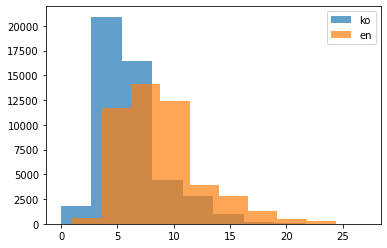

In [9]:
import matplotlib.pyplot as plt

len_ko = [len(x) for x in encoder_input]
len_en = [len(x) for x in decoder_input]

plt.hist(len_ko, label='ko', alpha=0.7)
plt.hist(len_en, label='en', alpha=0.7)
plt.legend()
plt.show()
# 번역은 손실이 조금만 생겨도 번역이 잘못될 수 있기 때문에 평균값보다는 max값을 사용

In [10]:
# maxlen의 default는 알아서 maxlen으로 들어감
encoder_input = pad_sequences(encoder_input, padding='post') # end 뒤는 보지 않도록 post를 지정해야 함
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_output = pad_sequences(decoder_output, padding='post')

In [11]:
print(encoder_input.shape)
print(decoder_input.shape)

(47667, 27)
(47667, 27)


In [12]:
# 단어 <-> index 변환용 
en_to_index = tokenizer_en.word_index
index_to_en = tokenizer_en.index_word

In [13]:
# split train, test (3:1)
test_size = 12000 # 전체 48000개 중
encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_output_train = decoder_output[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_output_test = decoder_output[-test_size:]

# Training

In [14]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [15]:
# 인코더 모델 - 한글 문장을 받아서 LSTM의 은닉/셀 상태를 리턴
encoder_inputs = Input(shape=(27,))  # padding 후 길이 
encoder_embed = Embedding(len(tokenizer_ko.word_index)+1, 50)(encoder_inputs) # 50은 hyperparameter
encoder_mask = Masking(mask_value=0)(encoder_embed) # 0인 값은 버리고 봐라

# LSTM
# return_state=True를 통해 마지막 은닉 상태/마지막 셀 상태 값을 리턴
# LSTM 한 시점의 출력은 은닉 상태값 -> 이것이 softmax 같은 함수를 통과하면서 y가 됨
encoder_output, h_state, c_state = LSTM(50, return_state=True)(encoder_mask) # encoder_output = h_state

In [16]:
# 디코더 모델 - 인코더 상태 값과, 영어 단어 입력을 받아서 LSTM의 출력값(은닉 상태)을 받아서 softmax 함수를 통과시키면 y가 출력됨
decoder_inputs = Input(shape=(27,))
decoder_embed = Embedding(len(tokenizer_en.word_index)+1, 50)(decoder_inputs)
decoder_mask = Masking(mask_value=0)(decoder_embed)

# return_sequences는 전체 시점의 은닉 상태 값만을 리턴(각 단어 인풋 별 은닉 상태 값)
# 아래의 코드는 return_state, return_sequences를 모두 사용했기 때문에
# 전체 시점의 은닉 상태 값/마지막 은닉 상태값/마지막 셀 상태 값이 리턴됨
# >> return state는 마지막 h,c만, return sequence는 매 시점마다의 h

# prediction을 위해서 함수형으로 사용하지 않고 layer를 저장해서 사용
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
# decoder는 마지막 시점의 은닉/셀 상태 값이 중요하지 않아서 더미 변수로 받음
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=[h_state, c_state])
decoder_dense = Dense(len(tokenizer_en.word_index)+1, activation='softmax')
decoder_softmax_outputs = decoder_dense(decoder_outputs)

In [17]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# sparse는 라벨(y)이 정수 형태로 제공될 때, categorical은 one-hot vector로 제공될 때 사용
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_output_train, validation_data = ([encoder_input_test, decoder_input_test], decoder_output_test), batch_size = 128, epochs=50, callbacks=[early_stop])

Epoch 1/50
279/279 [==============================] - 64s 228ms/step - loss: 3.4443 - accuracy: 0.6885 - val_loss: 2.2692 - val_accuracy: 0.6918
Epoch 2/50
279/279 [==============================] - 61s 220ms/step - loss: 1.9778 - accuracy: 0.7301 - val_loss: 2.1963 - val_accuracy: 0.6968
Epoch 3/50
279/279 [==============================] - 62s 221ms/step - loss: 1.9077 - accuracy: 0.7374 - val_loss: 2.1290 - val_accuracy: 0.7050
Epoch 4/50
279/279 [==============================] - 62s 221ms/step - loss: 1.8500 - accuracy: 0.7412 - val_loss: 2.0837 - val_accuracy: 0.7077
Epoch 5/50
279/279 [==============================] - 62s 221ms/step - loss: 1.8046 - accuracy: 0.7443 - val_loss: 2.0462 - val_accuracy: 0.7098
Epoch 6/50
279/279 [==============================] - 62s 220ms/step - loss: 1.7614 - accuracy: 0.7489 - val_loss: 2.0140 - val_accuracy: 0.7165
Epoch 7/50
279/279 [==============================] - 62s 221ms/step - loss: 1.7213 - accuracy: 0.7533 - val_loss: 1.9825 - val_ac

In [ ]:
from keras.models import load_model
# model.save('par_corp_seq2seq_epochs_50.h5')
# model = load_model('par_corp_seq2seq_epochs_50.h5') # loss: 1.2487 - accuracy: 0.8153 - val_loss: 2.1738 - val_accuracy: 0.7183

# Prediction

- train할 때는 decoder input을 알지만, prediction으로 할 땐 decoder input을 몰라서. 모델만 가지고 prediction을 할 수 없음. process 만들어줘야 함.

In [19]:
# 인코더가 출력하는 마지막 시점의 셀/은닉 상태 값을 따로 구하고
# <start> 라는 인풋을 따로 디코더 모델(lstm)에 넣어서
# 디코더 모델(lstm)에서 내는 output을 다시 디코더 모델(lstm)에 계속 넣어주는 형태로 구현
# 그러다가 <end>가 나타나면 멈춘다
 
# 가중치는 model train에서 레이어별로 학습되어있으므로 이 가중치를 가져와서 사용함.
encoder_model = Model(encoder_inputs, [h_state, c_state]) # input, output

In [20]:
# 디코더 모델
  # decoder에서는 시퀀스를 넣는 것이 아니라, 단어를 하나씩 넣을 것 
  # 따라서 상태값(h)이 자동으로 넘겨지지 않아서 직접 넘겨줘야 한다. 
encoder_h_state = Input(shape=(50,)) # lstm output_dim = 50
encoder_c_state = Input(shape=(50,)) 

pd_decoder_outputs, pd_h_state, pd_c_state = decoder_lstm(decoder_mask, initial_state=[encoder_h_state, encoder_c_state]) # 위에서 학습한 결과를 사용
pd_decoder_softmax_outputs = decoder_dense(pd_decoder_outputs)
  # 디코더 인풋(단어 1개), 인코더의 상태값이 인풋으로 들어감
  # lstm 셀을 통과하면서 예측, softmax 함수를 통과한 출력값(단어별 확률값)과 디코더의 상태값을 각각 출력해야 함
  # softmax 함수를 통과한 출력값(확률)을 토대로 다음 단어를 확정
  # 확정된 단어와 전 단계의 디코더의 상태값이 다음 인풋으로 들어간다.
    # input에 있는 [encoder_h_state, encoder_c_state]는 단계가 넘어가면 전 단계에 대한 h_state, c_state를 의미하게 됨
decoder_model = Model([decoder_inputs] + [encoder_h_state, encoder_c_state], [pd_decoder_softmax_outputs] + [pd_h_state, pd_c_state])

In [26]:
input_stc = input()
token_stc = input_stc.split()
encode_stc = tokenizer_ko.texts_to_sequences([token_stc])
pad_stc = pad_sequences(encode_stc, maxlen=27, padding='post')

states_value = encoder_model.predict(pad_stc)

predicted_seq = np.zeros((1, 1)) 
predicted_seq[0, 0] = en_to_index['<start>']

decoded_stc = []

while True:
    output_words, h, c = decoder_model.predict([predicted_seq] + states_value)
    # print(output_words[0,0])

    predicted_word = index_to_en[np.argmax(output_words[0,0])]
    
    if predicted_word == '<end>':
        break

    decoded_stc.append(predicted_word)
    
    predicted_seq = np.zeros((1, 1))
    predicted_seq[0, 0] = np.argmax(output_words[0, 0])  
    states_value = [h, c]

print(' '.join(decoded_stc))

젖은 성냥은 그어도 켜지지 않는다
the cat is the wall of the
